In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
from pyDOE import lhs
import shutil

import argparse

# 设置随机数种子
torch.manual_seed(123)
np.random.seed(123)

print(f'Device info: {torch.cuda.get_device_name()}')

Device info: GeForce GTX 1050 Ti


# 实验报告

姓名：江金阳

学号：2017301000090


## 0 概要

报告中对原论文各个算例的结果分别进行了复现，其中Burgers方程和Shrödinger方程的实现思想与原文相同，都采用了连续时间的模型，选取MSEloss，将PDE各式嵌入DNN的loss函数中得到PINN框架，最终的结果与作者提供的数值结果几乎吻合，效果理想。

而在Allen-Cahn方程的实现中，因为两点原因我最终**沿用了Shrödinger方程的实现思想**而没有使用作者的，其一，作者的loss计算是在已知数值解的前提下进行的，作者的工作可能只是建立了一个较强的拟合网络；其二，作者用Runge-Kutta方法将PDE转化为离散形式地嵌入loss函数中这一做法需要在多层新增较多个神经元，我所使用设备的显存在合理的超参数下始终无法支持运行下来。在我自己的实现方式下，所取得的结果与作者的结果有少许差别，主要是PDE解的正中位置的细节表现得不够理想，根据下面对照实验中的结论，适当增加网络的隐藏元个数和取样密度，提高网络对细节特征的学习应该可以取得更理想的结果。

**根据Burgers方程和Shrödinger方程的对照实验结果，我得出了如下的定性结论：**

1.相同的超参数下，PINN和ResPINN相比，ResPINN的学习效率更高，loss下降得更快；此外在调参过程中发现，ResPINN更为稳定高效，可以允许使用更深的隐藏层数而不发生梯度弥散或梯度爆炸，但对于PINN来说，粗暴地叠加网络深度后会有网络退化的问题，在超过某个层数后训练误差不降反升。

2.固定隐藏元个数，隐藏层/残差块数越多，网络越深，网络的泛化能力越好，可以在训练数据中学到更抽象的特征。

3.固定隐藏层数/残差块数，隐藏元个数越多，网络越宽，网络对训练数据的细节特征学习得越好，是一个好的“拟合”工具，但是泛化能力不足，更换数据后所得结果不尽理想。

4.过高的隐藏元个数、隐藏层数/残差块数和过大的训练轮数都可以导致过拟合，但相比较而言宽网络比深网络更容易过拟合。

**具体的对照实验结果见各章末尾。**


## 1、基础网络结构

网络结构分为普通的和带残差的全连接前馈神经网络(Fully-Connected Feedforward Network)，选择其中一种来实现。

### DNN

In [2]:
def activation(name):
    '''
    Activation function switcher
    '''
    if name.upper() == 'TANH':
        return nn.Tanh()
    elif name.upper() == 'RELU':
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name.upper() == 'SIGMOID':
        return nn.Sigmoid()
    elif name.upper() == 'SOFTPLUS':
        return nn.Softplus()
    else: 
        raise ValueError(f'Unknown activation function: {name}')

In [3]:
class DNN(nn.Module):
    '''
    Deep Neural Network
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name = 'tanh', init_name = 'kaiming_normal'):
        super().__init__()
        model = nn.Sequential()
        
        model.add_module('fc0',nn.Linear(dim_in, dim_hidden, bias = True))
        model.add_module('act0', activation(act_name))

        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
             
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
             
        if init_name is not None:
            self.init_weight(init_name)
    
    def init_weight(self, init_name):
        if init_name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif init_name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif init_name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif init_name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {init_name}')
            
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

### ResDNN

In [4]:
class ResBlock(nn.Module):
    '''
    Residual Block 
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, act_name='tanh'):
        super().__init__()

        assert(dim_in == dim_out)
        
        block = nn.Sequential()
        block.add_module('act', activation(act_name))
        block.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        block.add_module('fc1', nn.Linear(dim_hidden, dim_out, bias=True))
        self.block = block

    def forward(self, x):
        res = x
        out = self.block(x)
        return res + out

In [5]:
class ResDNN(nn.Module):
    '''
    Residual Deep Neural Network 
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks,
                 act_name = 'tanh', init_name = 'kaiming_normal'):
        super().__init__()
        
        model = nn.Sequential()
        model.add_module('fc_first', nn.Linear(dim_in, dim_hidden, bias = True))
        
        for i in range(res_blocks):
            res_block = ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name = act_name)
            model.add_module(f'res_block{i+1}', res_block)
        
        model.add_module('act_last', activation(act_name))
        model.add_module('fc_last', nn.Linear(dim_hidden, dim_out, bias = True))
        
        self.model = model
        
        if init_name is not None:
            self.init_weight(init_name)
        
    def init_weight(self, init_name):
        if init_name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif init_name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif init_name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif init_name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {init_name}')
            
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)         

## 2、Burgers方程

考虑一维Burgers方程：
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

### 2.1、问题描述

In [6]:
class Problem_Burgers(object):
    '''
    Description of Burgers Equation
    
    Params
    ====
    x:(N,2)ndarray
    x[:,[0]] - x , x[:,[1]]  - t
    '''
    
    def __init__(self, domain = (-1, 1, 0, 1)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    def f(self, x, verbose = None):
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out
    
    def ic(self, x, verbose = None):
        '''initial condition'''
        out = - np.sin(np.pi*x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out
    
    def bc(self, x, verbose = None):
        '''Dirichlet boundary condition'''
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out

### 2.2、数据集生成

In [7]:
class Trainset_Burgers(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            x, x_ic, x_bc = self._uniform_sample(n_x, n_t)
        elif self.method == 'lhs':
            n, n_ic, n_bc = self.args[0], self.args[1], self.args[2]
            x, x_ic, x_bc = self._lhs_sample(n, n_ic, n_bc)
        f = self.problem.f(x)
        ic = self.problem.ic(x_ic)
        bc = self.problem.bc(x_bc)
        
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_ic[:, 0], x_ic[:, 1], facecolor='b', s=10)
            ax.scatter(x_bc[:, 0], x_bc[:, 1], facecolor='g', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show()
            
        if verbose is not None:
            x = torch.from_numpy(x).float().cuda()
            x_ic = torch.from_numpy(x_ic).float().cuda()
            x_bc = torch.from_numpy(x_bc).float().cuda()
            f = torch.from_numpy(f).float().cuda()
            ic = torch.from_numpy(ic).float().cuda()
            bc = torch.from_numpy(bc).float().cuda()
            return x, x_ic, x_bc, f, ic, bc
        return x, x_ic, x_bc, f, ic, bc
        
    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        xt = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        
        mask1 =  (xt[:, 1] - t_min) == 0
        x_ic =xt[mask1]
        
        mask2 = (xt[:, 0] - x_min) * (x_max - xt[:, 0])== 0
        x_bc = xt[mask2]
        x = xt[np.logical_not(mask1 + mask2)]

        return x, x_ic, x_bc
        
    def _lhs_sample(self, n, n_ic, n_bc):
        x_min, x_max, t_min, t_max = self.domain

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_max])
        x = lb + (ub - lb) * lhs(2, n)

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_min])
        x_ic = lb + (ub - lb) * lhs(2, n_ic)

        lb = np.array([x_min, t_min])
        ub = np.array([x_min, t_max])
        x_bc = lb + (ub - lb) * lhs(2, n_bc//2)

        lb = np.array([x_max, t_min])
        ub = np.array([x_max, t_max])
        temp = lb + (ub - lb) * lhs(2, n_bc//2)
        x_bc = np.vstack((x_bc, temp))
        
        return x, x_ic, x_bc

In [8]:
class Testset_Burgers(object):
    """Dataset on a square domain"""
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            X, x, t = self._uniform_sample(n_x, n_t)
        
        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float().cuda() 
        return X, x, t

    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        X = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        return X, x, t


### 2.3、网络结构

In [9]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [10]:
class PINN_Burgers(DNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_bc=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]        
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]

        x.detach_()   

        f = u_t + u*u_x - (0.01/np.pi)*u_xx
        
        if x_ic is not None:
            if x_bc is not None:
                ic = super().forward(x_ic)
                bc = super().forward(x_bc)
                return u, f, ic, bc
            else:
                ic = super().forward(x_ic)
                return u, f, ic
        elif x_bc is not None:
            bc = super().forward(x_bc)
            return u, f, bc
        return u, f

In [11]:
class ResPINN_Burgers(ResDNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_bc=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]        
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]

        x.detach_()   

        f = u_t + u*u_x - (0.01/np.pi)*u_xx
        
        if x_ic is not None:
            if x_bc is not None:
                ic = super().forward(x_ic)
                bc = super().forward(x_bc)
                return u, f, ic, bc
            else:
                ic = super().forward(x_ic)
                return u, f, ic
        elif x_bc is not None:
            bc = super().forward(x_bc)
            return u, f, bc
        return u, f

### 2.4、Options

In [12]:
class Options_Burgers(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=20, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=6, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=2500, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=500, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='lhs', help='sample method')
        parser.add_argument('--n_x', type=int, default=256, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_t', type=int, default=100, help='sample points in t-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_ic', type=int, default=400, help='sample points at t = 0 for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--case', type=int, default=1, help='problem case')
        self.parser = parser
        
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if not arg.no_cuda and torch.cuda.is_available() else 'cpu')
        return arg

### 2.5、训练过程

Parameters of the neural networks can be learned by minimizing the mean squared error loss

$$MSE = MSE_f+MSE_u$$

where

$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,\quad MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}|u(t_u^i,x_u^i)-u^i|^2$$

Here, $\{t_u^i,x_u^i,u^i\}_{i=1}^{N_u}$ denote the initial and boundary training data.

In [13]:
def save_model_Burgers(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model_Burgers.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model_Burgers.pth.tar')
        shutil.copyfile(last_model, best_model)

In [18]:
class Trainer_Burgers(object):
    def __init__(self, args):
        self.device  = args.device
        print(f'Working device: {self.device}')
        
        self.lam = args.lam
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), max_iter=20, tolerance_grad=1.e-8, tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, step_size=args.step_size, gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x,     self.x_ic,     self.x_bc,     self.f,     self.ic,     self.bc     = args.trainset(verbose='tensor')
        self.x_val, self.x_ic_val, self.x_bc_val, self.f_val, self.ic_val, self.bc_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x,     self.x_ic,     self.x_bc,     self.f,     self.ic,     self.bc    ]:
                item = item.to(self.device)
            for item in [self.x_val, self.x_ic_val, self.x_bc_val, self.f_val, self.ic_val, self.bc_val]:
                item = item.to(self.device)
                
        ic_bc_points = np.vstack([self.x_ic.clone().detach().cpu(), self.x_bc.clone().detach().cpu()])
        np.save('ic_bc_points_Burgers.npy',ic_bc_points)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path

    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, f_pred, ic_pred, bc_pred = self.model(self.x, self.x_ic, self.x_bc)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(ic_pred, self.ic)
        loss3 = self.criterion(bc_pred, self.bc)
        loss = loss1 + self.lam * (loss2 + loss3)

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()

    def infos_Adam(self, epoch, loss, loss1, loss2, loss3):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam} * ({loss2:.4e}+{loss3:.4e}) ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, ic_pred, bc_pred = self.model(self.x, self.x_ic, self.x_bc)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(ic_pred, self.ic)
        loss3 = self.criterion(bc_pred, self.bc)
        
        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, f_pred, ic_pred, bc_pred = self.model(self.x, self.x_ic, self.x_bc)
            loss1 = self.criterion(f_pred, self.f)
            loss2 = self.criterion(ic_pred, self.ic)
            loss3 = self.criterion(bc_pred, self.bc)
            loss = loss1 + self.lam * (loss2 + loss3)
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.2e} = {loss1:.2e} + {self.lam:d} * ({loss2:.4e}+{loss3:.4e}) '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, ic_pred, bc_pred = self.model(self.x_val, self.x_ic_val, self.x_bc_val)
        loss1 = self.criterion(f_pred, self.f_val)
        loss2 = self.criterion(ic_pred, self.ic_val)
        loss3 = self.criterion(bc_pred, self.bc_val)
        loss = loss1 + self.lam * (loss2 + loss3)
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()

    def train(self):
        best_loss = 1.e10
        train_losses_index = []
        train_losses = []
        valid_losses_index = []
        valid_losses = []
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3 = self.train_Adam()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_Burgers(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3 = self.train_LBFGS()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_Burgers(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]

        # save loss curve info
        np.save('Burgers_loss.npy',[train_losses_index,train_losses,valid_losses_index,valid_losses])
        
        # loss curve
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        ax.set_title('Loss curve',usetex = True,fontsize=20)
        ax.set_yscale("log")
        ax.set_xlabel('epoch',usetex = True,fontsize=20)
        ax.set_ylabel('loss',usetex = True,fontsize=20)
        ax.plot(train_losses_index, train_losses, color = 'g', label = 'train loss')
        ax.plot(valid_losses_index, valid_losses, color = 'r', linestyle='--', label = 'valid loss')
        ax.legend(frameon=False, loc = 'best')
        plt.savefig('Burgers_train')
        plt.show()

Working device: cuda


d:\program files (x86)\python\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Adam  Epoch #  100/3000 Loss: 1.6161e-01 = 5.2081e-02 + 1 * (9.7494e-02+1.2037e-02) lr: 1.00e-03 
Valid Epoch #  100/3000 Loss: 1.6083e-01 
Adam  Epoch #  200/3000 Loss: 1.4059e-01 = 5.4297e-02 + 1 * (8.0346e-02+5.9460e-03) lr: 1.00e-03 
Valid Epoch #  200/3000 Loss: 1.4034e-01 
Adam  Epoch #  300/3000 Loss: 1.2422e-01 = 5.0384e-02 + 1 * (7.0600e-02+3.2323e-03) lr: 1.00e-03 
Valid Epoch #  300/3000 Loss: 1.2384e-01 
Adam  Epoch #  400/3000 Loss: 1.0870e-01 = 4.6047e-02 + 1 * (6.1423e-02+1.2299e-03) lr: 1.00e-03 
Valid Epoch #  400/3000 Loss: 1.0893e-01 
Adam  Epoch #  500/3000 Loss: 1.0173e-01 = 4.3397e-02 + 1 * (5.7738e-02+6.0006e-04) lr: 1.00e-03 
Valid Epoch #  500/3000 Loss: 1.0167e-01 
Adam  Epoch #  600/3000 Loss: 9.7282e-02 = 4.1445e-02 + 1 * (5.5367e-02+4.6970e-04) lr: 1.00e-03 
Valid Epoch #  600/3000 Loss: 9.7129e-02 
Adam  Epoch #  700/3000 Loss: 9.1701e-02 = 3.9163e-02 + 1 * (5.2258e-02+2.7951e-04) lr: 1.00e-03 
Valid Epoch #  700/3000 Loss: 9.2626e-02 
Adam  Epoch #  800/3

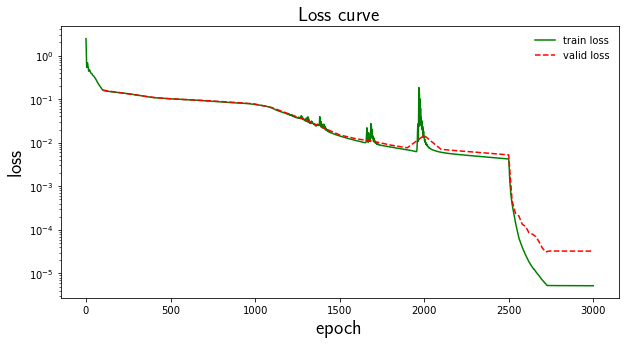

In [19]:
# 使用Trainer_Burgers进行训练
args = Options_Burgers().parse()
args.problem = Problem_Burgers()

#args.model = PINN_Burgers(2, 1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)

if args.sample_method == 'uniform':
    args.trainset = Trainset_Burgers(args.problem, args.n_x, args.n_t, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Burgers(args.problem, args.n, args.n_ic, args.n_bc, method='lhs')

args.validset = Trainset_Burgers(args.problem, 100, 100, method='uniform')
    
trainer = Trainer_Burgers(args)
trainer.train()

### 2.6、测试过程

In [20]:
class Tester_Burgers(object):
    def __init__(self, args):
        self.device  = args.device

        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model_Burgers.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.x, self.t = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        u_pred, _ = self.model(self.X)
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)
        
        n_t = u_pred.shape[0]
        
        # slide time index
        n_t_1 = int(n_t*0.25 - 1)
        n_t_2 = int(n_t*0.50 - 1)
        n_t_3 = int(n_t*0.75 - 1)
        
        # Loading exact solutions:
        data = scipy.io.loadmat('burgers_shock.mat')
        Exact_t = data['t'].flatten()[:,None] # 256*1
        Exact_x = data['x'].flatten()[:,None] # 100*1
        Exact_u= np.real(data['usol'])

        # u:plot
        fig = plt.figure(figsize=(12,3))
        ax = fig.add_subplot(111)
        h = ax.imshow(u_pred.T, interpolation='nearest', cmap='rainbow',
                      extent=[self.t.min(), self.t.max(), self.x.min(), self.x.max()], origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)
        
        ic_bc_points = np.load('ic_bc_points_Burgers.npy')
        ax.plot(ic_bc_points[:,1], ic_bc_points[:,0], 'kx', 
                label = 'IC and BC Data (%d points)' % (ic_bc_points.shape[0]), markersize = 4, clip_on = False)
        ax.legend(loc='upper right',frameon=False, fontsize=12)
    
        line = np.linspace(self.x.min(), self.x.max(), 2)[:,None]
        ax.plot((self.t[-1,-1]*n_t_1)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_2)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_3)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)    
    
        ax.set_xlabel('$t$',usetex = True,fontsize=20)
        ax.set_ylabel('$x$',usetex = True,fontsize=20)
        ax.set_title('$u(t,x)$',usetex = True,fontsize=20)
        plt.savefig('Burgers_1')
        plt.show()
        
        # u:slide plots
        fig = plt.figure(figsize=(15,3))
        ax = fig.add_subplot(131)
        ax.plot(self.x[0,:], u_pred[n_t_1,:], linewidth = 3, label = 'Predict')       
        ax.plot(Exact_x, Exact_u[:,n_t_1], linestyle = '--', linewidth = 3, label = 'Exact')    
        ax.set_title('$t = %.2f$' % (self.t[n_t_1,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
 
        ax = fig.add_subplot(132)
        ax.plot(self.x[0,:], u_pred[n_t_2,:], linewidth = 3, label = 'Predict')
        ax.plot(Exact_x, Exact_u[:,n_t_2], linestyle = '--', linewidth = 3, label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_2,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
        
        ax = fig.add_subplot(133)
        ax.plot(self.x[0,:], u_pred[n_t_3,:], linewidth = 3, label = 'Predict')
        ax.plot(Exact_x, Exact_u[:,n_t_3], linestyle = '--', linewidth = 3, label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_3,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
        
        plt.savefig('Burgers_2')
        plt.show()

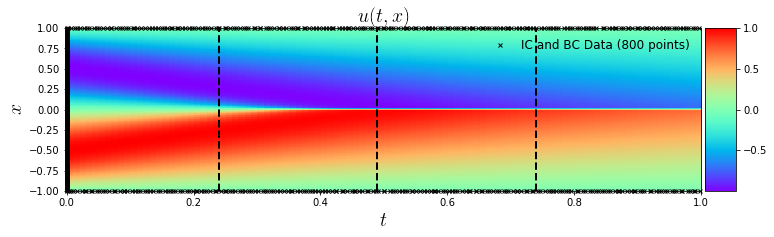

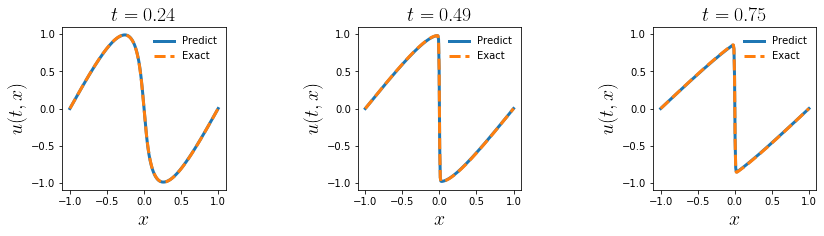

In [21]:
# 使用Tester_Burgers进行预测，复现文章中的Figure1
args = Options_Burgers().parse()
args.problem = Problem_Burgers()

args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Burgers(args.problem, args.n_x, args.n_t, method='uniform')  

tester = Tester_Burgers(args)
tester.predict()

### 2.7、对照实验

In [ ]:
# 对照试验代码，三组对照试验均由本节代码修改完成
less = np.load('.\\B hidden layers\\less\\Burgers_loss.npy', allow_pickle=True)
more = np.load('.\\B hidden layers\\more\\Burgers_loss.npy', allow_pickle=True)

# loss curve
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('Loss curve',usetex = True,fontsize=20)
ax.set_yscale("log")
ax.set_xlabel('epoch',usetex = True,fontsize=20)
ax.set_ylabel('loss',usetex = True,fontsize=20)
ax.plot(less[0], less[1], color = 'g', label = 'less hidden layers train loss')
ax.plot(less[2], less[3], color = 'r', linestyle='--', label = 'less hidden layers valid loss')
ax.plot(more[0], more[1], color = 'b', label = 'more hidden layers train loss')
ax.plot(more[2], more[3], color = 'y', linestyle='--', label = 'more hidden layers valid loss')
ax.legend(frameon=False, loc = 'best')
plt.savefig('Burgers_train')
plt.show()


#### 2.7.1、在相同的超参数的情况下，PINN和ResPINN的比较
两者的loss曲线对比如下：
![jupyter](Data/B_PINN_and_ResPINN/Burgers_train.png) 
PINN的结果如下：
![jupyter](Data/B_PINN_and_ResPINN/pinn/Burgers_2.png)
ResPINN的结果如下：
![jupyter](Data/B_PINN_and_ResPINN/respinn/Burgers_2.png)

#### 2.7.2、固定隐藏元个数，不同隐藏层数或残差块数对训练结果的影响：
两者的loss曲线对比如下：
![jupyter](Data/B_hidden_layers/Burgers_train.png) 
隐藏层数为2的结果如下：
![jupyter](Data/B_hidden_layers/less/Burgers_2.png)
隐藏层数为4的结果如下：
![jupyter](Data/B_hidden_layers/more/Burgers_2.png)

#### 2.7.3、固定隐藏层数或残差块数，不同隐藏元个数对训练结果的影响：
两者的loss曲线对比如下：
![jupyter](Data/B_neurons/Burgers_train.png) 
隐藏元个数为5的结果如下：
![jupyter](Data/B_neurons/less/Burgers_2.png)
隐藏元个数为10的结果如下：
![jupyter](Data/B_neurons/more/Burgers_2.png)

## 3、非线性薛定谔方程

考虑带周期边界条件的非线性薛定谔方程：
$$
\left\{
\begin{array}{rl}
i h_t + 0.5 h_{xx} + |h|^2 h = 0, & x \in[-5, 5], ~~ t \in [0, \pi/2]\\
h(0, x) = 2\mathrm{sech}(x), & \\
h(t,-5) = h(t, 5), & \\
h_x(t, -5) = h_x(t, 5), & 
\end{array}
\right.
$$
其中$h(t,x)$为复值函数。

### 3.1、问题描述

In [6]:
class Problem_Schrodinger(object):
    '''
    Description of Schrodinger Equation
    
    Params
    ====
    x:(N,2)ndarray
    x[:,[0]] - x , x[:,[1]]  - t
    '''
    
    def __init__(self, domain = (-5, 5, 0, np.pi/2)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    def f_u(self, x, verbose = None):
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out
    def f_v(self, x, verbose = None):
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out
    
    def ic_u(self, x, verbose = None):
        '''initial condition'''
        out = 2/np.cosh(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out
    def ic_v(self, x, verbose = None):
        '''initial condition'''
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out

### 3.2、数据集生成

In [7]:
class Trainset_Schrodinger(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            x, x_ic, x_lb, x_ub = self._uniform_sample(n_x, n_t)
        elif self.method == 'lhs':
            n, n_ic, n_lb, n_ub = self.args[0], self.args[1], self.args[2], self.args[3]
            x, x_ic, x_lb, x_ub = self._lhs_sample(n, n_ic, n_lb, n_ub)
        f_u = self.problem.f_u(x)
        f_v = self.problem.f_v(x)
        ic_u = self.problem.ic_u(x_ic)
        ic_v = self.problem.ic_v(x_ic)
        
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_ic[:, 0], x_ic[:, 1], facecolor='b', s=10)
            ax.scatter(x_lb[:, 0], x_lb[:, 1], facecolor='g', s=10)
            ax.scatter(x_ub[:, 0], x_ub[:, 1], facecolor='g', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show()
            
        if verbose is not None:
            x = torch.from_numpy(x).float().cuda()
            x_ic = torch.from_numpy(x_ic).float().cuda()
            x_lb = torch.from_numpy(x_lb).float().cuda()
            x_ub = torch.from_numpy(x_ub).float().cuda()
            f_u = torch.from_numpy(f_u).float().cuda()
            f_v = torch.from_numpy(f_v).float().cuda()
            ic_u = torch.from_numpy(ic_u).float().cuda()
            ic_v = torch.from_numpy(ic_v).float().cuda()
            return x, x_ic, x_lb, x_ub, f_u, f_v, ic_u, ic_v
        return x, x_ic, x_lb, x_ub, f_u, f_v, ic_u, ic_v
        
    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        xt = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        
        mask1 =  (xt[:, 1] - t_min) == 0
        x_ic =xt[mask1]
        mask2 = (xt[:, 0] - x_min) == 0
        x_lb = xt[mask2]
        mask3 = (x_max - xt[:, 0]) == 0
        x_ub = xt[mask3]
        
        x = xt[np.logical_not(mask1 + mask2 + mask3)]

        return x, x_ic, x_lb, x_ub
        
    def _lhs_sample(self, n, n_ic, n_lb, n_ub):
        x_min, x_max, t_min, t_max = self.domain

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_max])
        x = lb + (ub - lb) * lhs(2, n)

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_min])
        x_ic = lb + (ub - lb) * lhs(2, n_ic)

        lb = np.array([x_min, t_min])
        ub = np.array([x_min, t_max])
        x_lb = lb + (ub - lb) * lhs(2, n_lb)
        x_ub = x_lb.copy()
        x_ub[:,0] += x_max - x_min
        
        return x, x_ic, x_lb, x_ub

In [8]:
class Testset_Schrodinger(object):
    """Dataset on a square domain"""
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            X, x, t = self._uniform_sample(n_x, n_t)
        
        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float().cuda() 
        return X, x, t

    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        X = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        return X, x, t


### 3.3、网络结构


In [9]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [10]:
class PINN_Schrodinger(DNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_lb=None, x_ub=None):
        x.requires_grad_(True)
        # h = u + iv
        uv = super().forward(x)
        u = uv[:,0:1]
        v = uv[:,1:2]

        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]
        
        grad_v = grad(v, x)[0]     
        v_x = grad_v[:, [0]]
        v_t = grad_v[:, [1]]
        v_xx = grad(v_x, x)[0][:, [0]]

        x.detach_()   

        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u  
        
        if x_ic is not None:
            ic_uv = super().forward(x_ic)
            ic_u = ic_uv[:,0:1]
            ic_v = ic_uv[:,1:2]
            if x_lb is not None:
                x_lb.requires_grad_(True)
                lb_uv = super().forward(x_lb)
                lb_u = lb_uv[:,0:1]
                lb_v = lb_uv[:,1:2]
                lb_u_x = grad(lb_u, x_lb)[0][:, [0]]
                lb_v_x = grad(lb_v, x_lb)[0][:, [0]]
                x_lb.detach_()   
                if x_ub is not None:
                    x_ub.requires_grad_(True)
                    ub_uv = super().forward(x_ub)
                    ub_u = ub_uv[:,0:1]
                    ub_v = ub_uv[:,1:2]
                    ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
                    ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
                    x_ub.detach_()   
                    return u, v, f_u, f_v, ic_u, ic_v, lb_u, lb_v, ub_u, ub_v, lb_u_x, lb_v_x, ub_u_x, ub_v_x
                else:
                    return u, v, f_u, f_v, ic_u, ic_v, lb_u, lb_v, lb_u_x, lb_v_x
            else:
                return u, v, f_u, f_v, ic_u, ic_v
        elif x_lb is not None:
            x_lb.requires_grad_(True)
            lb_uv = super().forward(x_lb)
            lb_u = lb_uv[:,0:1]
            lb_v = lb_uv[:,1:2]
            lb_u_x = grad(lb_u, x_lb)[0][:, [0]]
            lb_v_x = grad(lb_v, x_lb)[0][:, [0]]
            x_lb.detach_()   
            if x_ub is not None:
                x_ub.requires_grad_(True)
                ub_uv = super().forward(x_ub)
                ub_u = ub_uv[:,0:1]
                ub_v = ub_uv[:,1:2]
                ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
                ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
                x_ub.detach_()   
                return u, v, f_u, f_v, lb_u, lb_v, ub_u, ub_v, lb_u_x, lb_v_x, ub_u_x, ub_v_x
            else:
                return u, v, f_u, f_v, lb_u, lb_v, lb_u_x, lb_v_x
        elif x_ub is not None:
            x_ub.requires_grad_(True)
            ub_uv = super().forward(x_ub)
            ub_u = ub_uv[:,0:1]
            ub_v = ub_uv[:,1:2]
            ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
            ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
            x_ub.detach_()   
            return u, v, f_u, f_v, ub_u, ub_v, ub_u_x, ub_v_x
        return u, v, f_u, f_v

In [11]:
class ResPINN_Schrodinger(ResDNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_lb=None, x_ub=None):
        x.requires_grad_(True)
        # h = u + iv
        uv = super().forward(x)
        u = uv[:,0:1]
        v = uv[:,1:2]

        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]
        
        grad_v = grad(v, x)[0]     
        v_x = grad_v[:, [0]]
        v_t = grad_v[:, [1]]
        v_xx = grad(v_x, x)[0][:, [0]]

        x.detach_()   

        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u  
        
        if x_ic is not None:
            ic_uv = super().forward(x_ic)
            ic_u = ic_uv[:,0:1]
            ic_v = ic_uv[:,1:2]
            if x_lb is not None:
                x_lb.requires_grad_(True)
                lb_uv = super().forward(x_lb)
                lb_u = lb_uv[:,0:1]
                lb_v = lb_uv[:,1:2]
                lb_u_x = grad(lb_u, x_lb)[0][:, [0]]
                lb_v_x = grad(lb_v, x_lb)[0][:, [0]]
                x_lb.detach_()   
                if x_ub is not None:
                    x_ub.requires_grad_(True)
                    ub_uv = super().forward(x_ub)
                    ub_u = ub_uv[:,0:1]
                    ub_v = ub_uv[:,1:2]
                    ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
                    ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
                    x_ub.detach_()   
                    return u, v, f_u, f_v, ic_u, ic_v, lb_u, lb_v, ub_u, ub_v, lb_u_x, lb_v_x, ub_u_x, ub_v_x
                else:
                    return u, v, f_u, f_v, ic_u, ic_v, lb_u, lb_v, lb_u_x, lb_v_x
            else:
                return u, v, f_u, f_v, ic_u, ic_v
        elif x_lb is not None:
            x_lb.requires_grad_(True)
            lb_uv = super().forward(x_lb)
            lb_u = lb_uv[:,0:1]
            lb_v = lb_uv[:,1:2]
            lb_u_x = grad(lb_u, x_lb)[0][:, [0]]
            lb_v_x = grad(lb_v, x_lb)[0][:, [0]]
            x_lb.detach_()   
            if x_ub is not None:
                x_ub.requires_grad_(True)
                ub_uv = super().forward(x_ub)
                ub_u = ub_uv[:,0:1]
                ub_v = ub_uv[:,1:2]
                ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
                ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
                x_ub.detach_()   
                return u, v, f_u, f_v, lb_u, lb_v, ub_u, ub_v, lb_u_x, lb_v_x, ub_u_x, ub_v_x
            else:
                return u, v, f_u, f_v, lb_u, lb_v, lb_u_x, lb_v_x
        elif x_ub is not None:
            x_ub.requires_grad_(True)
            ub_uv = super().forward(x_ub)
            ub_u = ub_uv[:,0:1]
            ub_v = ub_uv[:,1:2]
            ub_u_x = grad(ub_u, x_ub)[0][:, [0]]
            ub_v_x = grad(ub_v, x_ub)[0][:, [0]]
            x_ub.detach_()   
            return u, v, f_u, f_v, ub_u, ub_v, ub_u_x, ub_v_x
        return u, v, f_u, f_v

### 3.4、Options

In [12]:
class Options_Schrodinger(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=20, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=6, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
        parser.add_argument('--lam1', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lam2', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=2500, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=500, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=256, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_t', type=int, default=201, help='sample points in t-direction for uniform sample')
        parser.add_argument('--n', type=int, default=20000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_ic', type=int, default=400, help='sample points at t = 0 for lhs sample')
        parser.add_argument('--n_lb', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--n_ub', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--case', type=int, default=1, help='problem case')
        self.parser = parser
        
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if not arg.no_cuda and torch.cuda.is_available() else 'cpu')
        return arg

### 3.5、训练过程

Parameters of the neural networks can be learned by minimizing the mean squared error loss

$$MSE = MSE_f+MSE_0+MSE_b$$

where

$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,\quad MSE_0 = \frac{1}{N_0}\sum_{i=1}^{N_0}|h(0,x_0^i)-h_0^i|^2$$

$$MSE_b = \frac{1}{N_b}\sum_{i=1}^{N_b}(|h^i(t_b^i,-5)-h^i(t_b^i,5)|^2+|h_x^i(t_b^i,-5)-h_x^i(t_b^i,5)|^2)$$

In [13]:
def save_model_Schrodinger(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model_Schrodinger.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model_Schrodinger.pth.tar')
        shutil.copyfile(last_model, best_model)

In [14]:
class Trainer_Schrodinger(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        
        print(f'Working device: {self.device}')
        
        self.lam1 = args.lam1
        self.lam2 = args.lam2
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), max_iter=20, tolerance_grad=1.e-8, tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, step_size=args.step_size, gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x,     self.x_ic,     self.x_lb,     self.x_ub,     self.f_u,     \
        self.f_v,     self.ic_u,     self.ic_v   = args.trainset(verbose='tensor')
        
        self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val, self.f_u_val, \
        self.f_v_val, self.ic_u_val, self.ic_v_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x,     self.x_ic,     self.x_lb,     self.x_ub,     self.f_u,     self.f_v,     self.ic_u,     self.ic_v    ]:
                item = item.to(self.device)
            for item in [self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val, self.f_u_val, self.f_v_val, self.ic_u_val, self.ic_v_val]:
                item = item.to(self.device)
                
        ic_bc_points = np.vstack([self.x_ic.clone().detach().cpu(), self.x_lb.clone().detach().cpu(), self.x_ub.clone().detach().cpu()])
        np.save('ic_bc_points_Schrodinger.npy',ic_bc_points)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path
            
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, _, f_u_pred, f_v_pred, ic_u_pred, ic_v_pred, lb_u_pred, lb_v_pred, \
        ub_u_pred, ub_v_pred, lb_u_x_pred, lb_v_x_pred, ub_u_x_pred, ub_v_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)
        
        loss1 = self.criterion(ic_u_pred, self.ic_u) + self.criterion(ic_v_pred, self.ic_v)
        loss2 = self.criterion(lb_u_pred, ub_u_pred) + self.criterion(lb_v_pred, ub_v_pred) + \
        self.criterion(lb_u_x_pred, ub_u_x_pred) + self.criterion(lb_v_x_pred, ub_v_x_pred)
        loss3 = self.criterion(f_u_pred, self.f_u) + self.criterion(f_v_pred, self.f_v)
        loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()

    def infos_Adam(self, epoch, loss, loss1, loss2, loss3):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam1} * {loss2:.4e} + {self.lam2} * {loss3:.4e} ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, _, f_u_pred, f_v_pred, ic_u_pred, ic_v_pred, lb_u_pred, lb_v_pred, \
        ub_u_pred, ub_v_pred, lb_u_x_pred, lb_v_x_pred, ub_u_x_pred, ub_v_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)
        
        loss1 = self.criterion(ic_u_pred, self.ic_u) + self.criterion(ic_v_pred, self.ic_v)
        loss2 = self.criterion(lb_u_pred, ub_u_pred) + self.criterion(lb_v_pred, ub_v_pred) + \
        self.criterion(lb_u_x_pred, ub_u_x_pred) + self.criterion(lb_v_x_pred, ub_v_x_pred)
        loss3 = self.criterion(f_u_pred, self.f_u) + self.criterion(f_v_pred, self.f_v)
        
        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
                _, _, f_u_pred, f_v_pred, ic_u_pred, ic_v_pred, lb_u_pred, lb_v_pred, \
                ub_u_pred, ub_v_pred, lb_u_x_pred, lb_v_x_pred, ub_u_x_pred, ub_v_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)

                loss1 = self.criterion(ic_u_pred, self.ic_u) + self.criterion(ic_v_pred, self.ic_v)
                loss2 = self.criterion(lb_u_pred, ub_u_pred) + self.criterion(lb_v_pred, ub_v_pred) + \
                self.criterion(lb_u_x_pred, ub_u_x_pred) + self.criterion(lb_v_x_pred, ub_v_x_pred)
                loss3 = self.criterion(f_u_pred, self.f_u) + self.criterion(f_v_pred, self.f_v)
                loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam1} * {loss2:.4e} + {self.lam2} * {loss3:.4e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, _, f_u_pred, f_v_pred, ic_u_pred, ic_v_pred, lb_u_pred, lb_v_pred, \
        ub_u_pred, ub_v_pred, lb_u_x_pred, lb_v_x_pred, ub_u_x_pred, ub_v_x_pred = self.model(self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val)
        
        loss1 = self.criterion(ic_u_pred, self.ic_u_val) + self.criterion(ic_v_pred, self.ic_v_val)
        loss2 = self.criterion(lb_u_pred, ub_u_pred) + self.criterion(lb_v_pred, ub_v_pred) + \
        self.criterion(lb_u_x_pred, ub_u_x_pred) + self.criterion(lb_v_x_pred, ub_v_x_pred)
        loss3 = self.criterion(f_u_pred, self.f_u_val) + self.criterion(f_v_pred, self.f_v_val)
        loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()
    
    def train(self):
        best_loss = 1.e10
        train_losses_index = []
        train_losses = []
        valid_losses_index = []
        valid_losses = []
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3 = self.train_Adam()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_Schrodinger(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3 = self.train_LBFGS()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_Schrodinger(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]
                
        # save loss curve info
        np.save('Schrodinger_loss.npy',[train_losses_index,train_losses,valid_losses_index,valid_losses])
        
        # loss curve
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        ax.set_title('Loss curve',usetex = True,fontsize=20)
        ax.set_yscale("log")
        ax.set_xlabel('epoch',usetex = True,fontsize=20)
        ax.set_ylabel('loss',usetex = True,fontsize=20)
        ax.plot(train_losses_index, train_losses, color = 'g', label = 'train loss')
        ax.plot(valid_losses_index, valid_losses, color = 'r', linestyle='--', label = 'valid loss')
        ax.legend(frameon=False, loc = 'best')
        plt.savefig('Schrodinger_loss')
        plt.show()

Working device: cuda


d:\program files (x86)\python\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Adam  Epoch #  100/3000 Loss: 1.0302e-01 = 5.8839e-02 + 1 * 1.0567e-03 + 1 * 4.3122e-02 lr: 1.00e-03 
Valid Epoch #  100/3000 Loss: 1.0234e-01 
Adam  Epoch #  200/3000 Loss: 6.8165e-02 = 3.7395e-02 + 1 * 3.8061e-04 + 1 * 3.0389e-02 lr: 1.00e-03 
Valid Epoch #  200/3000 Loss: 6.8046e-02 
Adam  Epoch #  300/3000 Loss: 6.1924e-02 = 3.2961e-02 + 1 * 2.6601e-04 + 1 * 2.8697e-02 lr: 1.00e-03 
Valid Epoch #  300/3000 Loss: 6.1884e-02 
Adam  Epoch #  400/3000 Loss: 5.8516e-02 = 3.0903e-02 + 1 * 2.0911e-04 + 1 * 2.7404e-02 lr: 1.00e-03 
Valid Epoch #  400/3000 Loss: 5.8487e-02 
Adam  Epoch #  500/3000 Loss: 5.5823e-02 = 2.9044e-02 + 1 * 1.7117e-04 + 1 * 2.6608e-02 lr: 1.00e-03 
Valid Epoch #  500/3000 Loss: 5.5798e-02 
Adam  Epoch #  600/3000 Loss: 5.3428e-02 = 2.7420e-02 + 1 * 1.4690e-04 + 1 * 2.5861e-02 lr: 1.00e-03 
Valid Epoch #  600/3000 Loss: 5.3405e-02 
Adam  Epoch #  700/3000 Loss: 5.1220e-02 = 2.6096e-02 + 1 * 1.2792e-04 + 1 * 2.4995e-02 lr: 1.00e-03 
Valid Epoch #  700/3000 Loss: 5.11

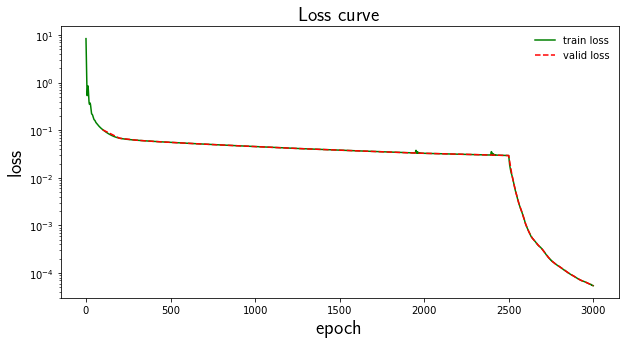

In [15]:
# 使用Trainer_Schrodinger进行训练
args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()

#args.model = PINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Schrodinger(args.problem, args.n_x, args.n_t, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Schrodinger(args.problem, args.n, args.n_ic, args.n_lb, args.n_ub, method='lhs')
args.validset = Trainset_Schrodinger(args.problem, 100, 100, method='uniform')
    
trainer = Trainer_Schrodinger(args)
trainer.train()

### 3.6、测试过程

In [16]:
class Tester_Schrodinger(object):
    def __init__(self, args):
        self.device  = args.device

        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints', model_name, 'best_model_Schrodinger.pth.tar')
                                  
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.x, self.t = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        u_pred, v_pred, _, _ = self.model(self.X)
        
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)
        v_pred = v_pred.detach().cpu().numpy()
        v_pred = v_pred.reshape(self.x.shape)
        
        h_abs_pred = np.sqrt(u_pred**2 + v_pred**2)
        n_t = h_abs_pred.shape[0]
        
        # slide time index
        n_t_1 = int(n_t*0.25 - 1)
        n_t_2 = int(n_t*0.624 - 1)
        n_t_3 = int(n_t*0.75 - 1)
        
        # Loading exact solutions:
        data = scipy.io.loadmat('NLS.mat')
        Exact_t = data['tt'].flatten()[:,None] # 1*256
        Exact_x = data['x'].flatten()[:,None]  # 1*201
        Exact = data['uu']
        Exact_u = np.real(Exact)
        Exact_v = np.imag(Exact)
        Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
        
        # h:plot
        fig = plt.figure(figsize=(12,3))
        ax = fig.add_subplot(111)
        h = ax.imshow(h_abs_pred.T, interpolation='nearest', cmap='YlGnBu',
                      extent=[self.t.min(), self.t.max(), self.x.min(), self.x.max()], origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)
        
        ic_bc_points = np.load('ic_bc_points_Schrodinger.npy')
        ax.plot(ic_bc_points[:,1], ic_bc_points[:,0], 'kx', 
                label = 'IC and BC Data (%d points)' % (ic_bc_points.shape[0]), markersize = 4, clip_on = False)
        ax.legend(loc='upper right',frameon=False, fontsize=12)
    
        line = np.linspace(self.x.min(), self.x.max(), 2)[:,None]
        ax.plot((self.t[-1,-1]*n_t_1)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_2)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_3)/n_t*np.ones((2,1)), line, 'k--', linewidth = 2)    
    
        ax.set_xlabel('$t$',usetex = True,fontsize=20)
        ax.set_ylabel('$x$',usetex = True,fontsize=20)
        ax.set_title('$|h(t,x)|$',usetex = True,fontsize=20)
        plt.savefig('Schrodinger_1')
        plt.show()
        
        # h:slide plots
        fig = plt.figure(figsize=(18,3))
        ax = fig.add_subplot(131)
        ax.plot(self.x[0,:], h_abs_pred[n_t_1,:], linewidth = 3, color='blue', label = 'Predict')       
        ax.plot(Exact_x, Exact_h[:,n_t_1], linestyle = '--', linewidth = 3, color='red', label = 'Exact')    
        ax.set_title('$t = %.2f$' % (self.t[n_t_1,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$|h(x,t)|$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        
        ax = fig.add_subplot(132)
        ax.plot(self.x[0,:], h_abs_pred[n_t_2,:], linewidth = 3, color='blue', label = 'Predict')
        ax.plot(Exact_x, Exact_h[:,n_t_2], linestyle = '--', linewidth = 3, color='red', label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_2,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$|h(x,t)|$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        
        ax = fig.add_subplot(133)
        ax.plot(self.x[0,:], h_abs_pred[n_t_3,:], linewidth = 3, color='blue', label = 'Predict')
        ax.plot(Exact_x, Exact_h[:,n_t_3], linestyle = '--', linewidth = 3, color='red', label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_3,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$|h(x,t)|$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
                     
        plt.savefig('Schrodinger_2')
        plt.show()

In [ ]:
# 使用Tester_Schrodinger进行预测，复现复现文章中的Figure2
args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()

args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Schrodinger(args.problem, args.n_x, args.n_t, method='uniform')  

tester = Tester_Schrodinger(args)
tester.predict()

### 3.7、对照试验

使用与**2.7**相同的作图代码，得到如下的结果：

#### 3.7.1、在相同的超参数的情况下，PINN和ResPINN的比较
两者的loss曲线对比如下：
![jupyter](Data/S_PINN_and_ResPINN/Schrodinger_train.png) 
PINN的结果如下：
![jupyter](Data/S_PINN_and_ResPINN/pinn/Schrodinger_2.png)
ResPINN的结果如下：
![jupyter](Data/S_PINN_and_ResPINN/respinn/Schrodinger_2.png)

#### 3.7.2、固定隐藏元个数，不同隐藏层数或残差块数对训练结果的影响：
两者的loss曲线对比如下：
![jupyter](Data/S_hidden_layers/Schrodinger_train.png) 
隐藏层数为4的结果如下：
![jupyter](Data/S_hidden_layers/less/Schrodinger_2.png)
隐藏层数为8的结果如下：
![jupyter](Data/S_hidden_layers/more/Schrodinger_2.png)

#### 3.7.3、固定隐藏层数或残差块数，不同隐藏元个数对训练结果的影响：
两者的loss曲线对比如下：
![jupyter](Data/S_neurons/Schrodinger_train.png) 
隐藏元个数为10的结果如下：
![jupyter](Data/S_neurons/less/Schrodinger_2.png)
隐藏元个数为20的结果如下：
![jupyter](Data/S_neurons/more/Schrodinger_2.png)

## 4、Allen-Cahn方程

考虑带周期边界条件的Allen-Cahn方程：
$$
\left\{
\begin{array}{rl}
u_t -  0.0001 u_{xx} + 5u^3 - 5 u = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = x^2\cos(\pi x), & \\
u(t,-1) = u(t, 1), & \\
u_x(t, -1) = u_x(t, 1).
\end{array}
\right.
$$


### 4.1、问题描述


In [6]:
class Problem_AC(object):
    '''
    Description of Allen-Cahn Equation
    
    Params
    ====
    x:(N,2)ndarray
    x[:,[0]] - x , x[:,[1]]  - t
    '''
    
    def __init__(self, domain = (-1, 1, 0, 1)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    def f(self, x, verbose = None):
        out = np.zeros_like(x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out

    def ic(self, x, verbose = None):
        '''initial condition'''
        out = (x[:,[0]]**2) * np.cos(np.pi*x[:,[0]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float().cuda()
        return out

### 4.2、数据集生成

In [7]:
class Trainset_AC(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            x, x_ic, x_lb, x_ub = self._uniform_sample(n_x, n_t)
        elif self.method == 'lhs':
            n, n_ic, n_lb, n_ub = self.args[0], self.args[1], self.args[2], self.args[3]
            x, x_ic, x_lb, x_ub = self._lhs_sample(n, n_ic, n_lb, n_ub)
        f = self.problem.f(x)
        ic = self.problem.ic(x_ic)
        
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_ic[:, 0], x_ic[:, 1], facecolor='b', s=10)
            ax.scatter(x_lb[:, 0], x_lb[:, 1], facecolor='g', s=10)
            ax.scatter(x_ub[:, 0], x_ub[:, 1], facecolor='g', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show()
            
        if verbose is not None:
            x = torch.from_numpy(x).float().cuda()
            x_ic = torch.from_numpy(x_ic).float().cuda()
            x_lb = torch.from_numpy(x_lb).float().cuda()
            x_ub = torch.from_numpy(x_ub).float().cuda()
            f = torch.from_numpy(f).float().cuda()
            ic = torch.from_numpy(ic).float().cuda()
            return x, x_ic, x_lb, x_ub, f, ic
        return x, x_ic, x_lb, x_ub, f, ic
        
    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        xt = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        
        mask1 =  (xt[:, 1] - t_min) == 0
        x_ic =xt[mask1]
        mask2 = (xt[:, 0] - x_min) == 0
        x_lb = xt[mask2]
        mask3 = (x_max - xt[:, 0]) == 0
        x_ub = xt[mask3]
        
        x = xt[np.logical_not(mask1 + mask2 + mask3)]

        return x, x_ic, x_lb, x_ub
        
    def _lhs_sample(self, n, n_ic, n_lb, n_ub):
        x_min, x_max, t_min, t_max = self.domain

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_max])
        x = lb + (ub - lb) * lhs(2, n)

        lb = np.array([x_min, t_min])
        ub = np.array([x_max, t_min])
        x_ic = lb + (ub - lb) * lhs(2, n_ic)

        lb = np.array([x_min, t_min])
        ub = np.array([x_min, t_max])
        x_lb = lb + (ub - lb) * lhs(2, n_lb//2)

        lb = np.array([x_max, t_min])
        ub = np.array([x_max, t_max])
        x_ub = lb + (ub - lb) * lhs(2, n_ub//2)
        
        return x, x_ic, x_lb, x_ub

In [8]:
class Testset_AC(object):
    """Dataset on a square domain"""
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_t = self.args[0], self.args[1]
            X, x, t = self._uniform_sample(n_x, n_t)
        
        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=10)
            ax.set_xlim(self.domain[0]-0.01, self.domain[1]+0.01)
            ax.set_ylim(self.domain[2]-0.01, self.domain[3]+0.01)
            ax.set_aspect('equal')
            plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float().cuda() 
        return X, x, t

    def _uniform_sample(self, n_x, n_t):
        x_min, x_max, t_min, t_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t = np.linspace(t_min, t_max, n_t)
        x, t = np.meshgrid(x, t)
        X = np.hstack((x.reshape(x.size, -1), t.reshape(t.size, -1)))
        return X, x, t


### 4.3、网络结构


In [9]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [10]:
class PINN_AC(DNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_lb=None, x_ub=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]

        x.detach_()   

        f = u_t - 0.0001*u_xx + 5*(u**3) - 5*u
        
        if x_ic is not None:
            ic = super().forward(x_ic)
            if x_lb is not None:
                x_lb.requires_grad_(True)
                lb = super().forward(x_lb)
                lb_x = grad(lb, x_lb)[0][:, [0]]
                x_lb.detach_()   
                if x_ub is not None:
                    x_ub.requires_grad_(True)
                    ub = super().forward(x_ub)
                    ub_x = grad(ub, x_ub)[0][:, [0]]
                    x_ub.detach_()   
                    return u, f, ic, lb, ub, lb_x, ub_x
                else:
                    return u, f, ic, lb, lb_x
            else:
                return u, f, ic
        elif x_lb is not None:
            x_lb.requires_grad_(True)
            lb = super().forward(x_lb)
            lb_x = grad(lb, x_lb)[0][:, [0]]
            x_lb.detach_()  
            if x_ub is not None:
                x_ub.requires_grad_(True)
                ub = super().forward(x_ub)
                ub_x = grad(ub, x_ub)[0][:, [0]]
                x_ub.detach_()   
                return u, f, lb, ub, lb_x, ub_x
            else:
                return u, f, lb, lb_x
        elif x_ub is not None:
            x_ub.requires_grad_(True)
            ub = super().forward(x_ub)
            ub_x = grad(ub, x_ub)[0][:, [0]]
            x_ub.detach_()   
            return u, f, ub, ub_x
        return u, f

In [11]:
class ResPINN_AC(ResDNN):
    '''
    Physics Constrained Neural Networks
    '''
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name = 'tanh', init_name = 'xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks, act_name = act_name, init_name = init_name)
        
    def forward(self, x, x_ic = None, x_lb=None, x_ub=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [0]]
        u_t = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]

        x.detach_()   

        f = u_t - 0.0001*u_xx + 5*(u**3) - 5*u
        
        if x_ic is not None:
            ic = super().forward(x_ic)
            if x_lb is not None:
                x_lb.requires_grad_(True)
                lb = super().forward(x_lb)
                lb_x = grad(lb, x_lb)[0][:, [0]]
                x_lb.detach_()   
                if x_ub is not None:
                    x_ub.requires_grad_(True)
                    ub = super().forward(x_ub)
                    ub_x = grad(ub, x_ub)[0][:, [0]]
                    x_ub.detach_()   
                    return u, f, ic, lb, ub, lb_x, ub_x
                else:
                    return u, f, ic, lb, lb_x
            else:
                return u, f, ic
        elif x_lb is not None:
            x_lb.requires_grad_(True)
            lb = super().forward(x_lb)
            lb_x = grad(lb, x_lb)[0][:, [0]]
            x_lb.detach_()  
            if x_ub is not None:
                x_ub.requires_grad_(True)
                ub = super().forward(x_ub)
                ub_x = grad(ub, x_ub)[0][:, [0]]
                x_ub.detach_()   
                return u, f, lb, ub, lb_x, ub_x
            else:
                return u, f, lb, lb_x
        elif x_ub is not None:
            x_ub.requires_grad_(True)
            ub = super().forward(x_ub)
            ub_x = grad(ub, x_ub)[0][:, [0]]
            x_ub.detach_()   
            return u, f, ub, ub_x
        return u, f

### 4.4、Options

In [45]:
class Options_AC(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=20, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=6, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
        parser.add_argument('--lam1', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lam2', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=2500, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=500, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=512, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_t', type=int, default=201, help='sample points in t-direction for uniform sample')
        parser.add_argument('--n', type=int, default=20000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_ic', type=int, default=400, help='sample points at t = 0 for lhs sample')
        parser.add_argument('--n_lb', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--n_ub', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--case', type=int, default=1, help='problem case')
        self.parser = parser
        
        
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if not arg.no_cuda and torch.cuda.is_available() else 'cpu')
        return arg

### 4.5、训练过程

Parameters of the neural networks can be learned by minimizing the mean squared error loss

$$MSE = MSE_f+MSE_0+MSE_b$$

where

$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,\quad MSE_0 = \frac{1}{N_0}\sum_{i=1}^{N_0}|u(0,x_0^i)-u_0^i|^2$$

$$MSE_b = \frac{1}{N_b}\sum_{i=1}^{N_b}(|u^i(t_b^i,-5)-u^i(t_b^i,5)|^2+|u_x^i(t_b^i,-5)-u_x^i(t_b^i,5)|^2)$$

In [46]:
def save_model_AC(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model_AC_Continuous.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model_AC_Continuous.pth.tar')
        shutil.copyfile(last_model, best_model)

In [47]:
class Trainer_AC(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        
        print(f'Working device: {self.device}')
        
        self.lam1 = args.lam1
        self.lam2 = args.lam2
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), max_iter=30, tolerance_grad=1.e-8, tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, step_size=args.step_size, gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x,     self.x_ic,     self.x_lb,     self.x_ub,     self.f,     self.ic     = args.trainset(verbose='tensor')
        self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val, self.f_val, self.ic_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x,     self.x_ic,     self.x_lb,     self.x_ub,     self.f,     self.ic    ]:
                item = item.to(self.device)
            for item in [self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val, self.f_val, self.ic_val]:
                item = item.to(self.device)
        
        ic_bc_points = np.vstack([self.x_ic.clone().detach().cpu(), self.x_lb.clone().detach().cpu(), self.x_ub.clone().detach().cpu()])
        np.save('ic_bc_points_AC.npy',ic_bc_points)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path
            
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, f_pred, ic_pred, lb_pred, ub_pred, lb_x_pred, ub_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)
        
        loss1 = self.criterion(ic_pred, self.ic)
        loss2 = self.criterion(lb_pred, ub_pred) +  self.criterion(lb_x_pred, ub_x_pred)
        loss3 = self.criterion(f_pred, self.f)
        loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()

    def infos_Adam(self, epoch, loss, loss1, loss2, loss3):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam1} * {loss2:.4e} + {self.lam2} * {loss3:.4e} ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, ic_pred, lb_pred, ub_pred, lb_x_pred, ub_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)

        loss1 = self.criterion(ic_pred, self.ic)
        loss2 = self.criterion(lb_pred, ub_pred) +  self.criterion(lb_x_pred, ub_x_pred)
        loss3 = self.criterion(f_pred, self.f)
        loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3
        
        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
                _, f_pred, ic_pred, lb_pred, ub_pred, lb_x_pred, ub_x_pred = self.model(self.x, self.x_ic, self.x_lb, self.x_ub)

                loss1 = self.criterion(ic_pred, self.ic)
                loss2 = self.criterion(lb_pred, ub_pred) +  self.criterion(lb_x_pred, ub_x_pred)
                loss3 = self.criterion(f_pred, self.f)
                loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3

            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam1} * {loss2:.4e} + {self.lam2} * {loss3:.4e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, ic_pred, lb_pred, ub_pred, lb_x_pred, ub_x_pred = self.model(self.x_val, self.x_ic_val, self.x_lb_val, self.x_ub_val)
        
        loss1 = self.criterion(ic_pred, self.ic_val)
        loss2 = self.criterion(lb_pred, ub_pred) +  self.criterion(lb_x_pred, ub_x_pred)
        loss3 = self.criterion(f_pred, self.f_val)
        loss = loss1 + self.lam1 * loss2 + self.lam2 * loss3
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()
    
    def train(self):
        best_loss = 1.e10
        train_losses_index = []
        train_losses = []
        valid_losses_index = []
        valid_losses = []
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3 = self.train_Adam()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_AC(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3 = self.train_LBFGS()
            train_losses_index += [epoch]
            train_losses += [loss]
            
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2, loss3)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model_AC(state, is_best, save_dir=self.model_path)
                valid_losses_index += [epoch]
                valid_losses += [valid_loss]
        
        # loss curve
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        ax.set_title('Loss curve',usetex = True,fontsize=20)
        ax.set_yscale("log")
        ax.set_xlabel('epoch',usetex = True,fontsize=20)
        ax.set_ylabel('loss',usetex = True,fontsize=20)
        ax.plot(train_losses_index, train_losses, color = 'g', label = 'train loss')
        ax.plot(valid_losses_index, valid_losses, color = 'r', linestyle='--', label = 'valid loss')
        ax.legend(frameon=False, loc = 'best')
        plt.savefig('AC_train')
        plt.show()

Working device: cuda


d:\program files (x86)\python\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Adam  Epoch #  100/3000 Loss: 1.1061e-01 = 8.5676e-02 + 1 * 1.7472e-03 + 1 * 2.3182e-02 lr: 1.00e-03 
Valid Epoch #  100/3000 Loss: 1.1034e-01 
Adam  Epoch #  200/3000 Loss: 9.1662e-02 = 7.8186e-02 + 1 * 5.7242e-04 + 1 * 1.2904e-02 lr: 1.00e-03 
Valid Epoch #  200/3000 Loss: 9.1541e-02 
Adam  Epoch #  300/3000 Loss: 8.3073e-02 = 7.0805e-02 + 1 * 7.3068e-04 + 1 * 1.1537e-02 lr: 1.00e-03 
Valid Epoch #  300/3000 Loss: 8.3005e-02 
Adam  Epoch #  400/3000 Loss: 7.6221e-02 = 6.4033e-02 + 1 * 1.0200e-03 + 1 * 1.1167e-02 lr: 1.00e-03 
Valid Epoch #  400/3000 Loss: 7.6147e-02 
Adam  Epoch #  500/3000 Loss: 6.7474e-02 = 5.5560e-02 + 1 * 1.1599e-03 + 1 * 1.0754e-02 lr: 1.00e-03 
Valid Epoch #  500/3000 Loss: 6.7368e-02 
Adam  Epoch #  600/3000 Loss: 5.4194e-02 = 4.3882e-02 + 1 * 1.0510e-03 + 1 * 9.2609e-03 lr: 1.00e-03 
Valid Epoch #  600/3000 Loss: 5.4034e-02 
Adam  Epoch #  700/3000 Loss: 3.6709e-02 = 2.9049e-02 + 1 * 8.8288e-04 + 1 * 6.7762e-03 lr: 1.00e-03 
Valid Epoch #  700/3000 Loss: 3.65

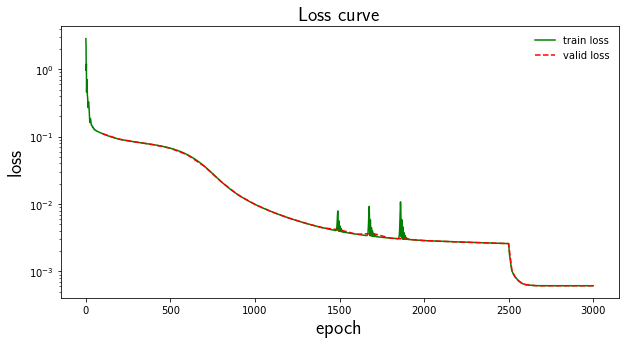

In [48]:
# 使用Trainer_AC进行训练
args = Options_AC().parse()
args.problem = Problem_AC()

args.model = ResPINN_AC(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_AC(args.problem, args.n_x, args.n_t, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_AC(args.problem, args.n, args.n_ic, args.n_lb, args.n_ub, method='lhs')
args.validset = Trainset_AC(args.problem, 200, 100, method='uniform')
    
trainer = Trainer_AC(args)
trainer.train()

### 4.6、测试过程

In [51]:
class Tester_AC(object):
    def __init__(self, args):
        self.device  = args.device

        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints', model_name, 'best_model_AC_Continuous.pth.tar')
                                  
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.x, self.t = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        u_pred, _ = self.model(self.X)
        
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)

        n_t = u_pred.shape[0]
        
        # slide time index
        n_t_1 = int(n_t*0.10 - 1)
        n_t_2 = int(n_t*0.40 - 1)
        n_t_3 = int(n_t*0.70 - 1)
        
        # Loading exact solutions:
        data = scipy.io.loadmat('AC.mat')
        
        Exact_t = data['tt'].flatten()[:,None] # 1*512
        Exact_x = data['x'].flatten()[:,None]  # 1*201
        Exact_u = data['uu']                   # 512*201

        # h:plot
        fig = plt.figure(figsize=(12,3))
        ax = fig.add_subplot(111)
        h = ax.imshow(u_pred.T, interpolation='nearest', cmap='seismic',
                      extent=[self.t.min(), self.t.max(), self.x.min(), self.x.max()], origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)
        
        ic_bc_points = np.load('ic_bc_points_AC.npy')
        ax.plot(ic_bc_points[:,1], ic_bc_points[:,0], 'kx', 
                label = 'IC and BC Data (%d points)' % (ic_bc_points.shape[0]), markersize = 4, clip_on = False)
        ax.legend(loc='upper right',frameon=False, fontsize=12)
    
        line = np.linspace(self.x.min(), self.x.max(), 2)[:,None]
        ax.plot((self.t[-1,-1]*n_t_1)/n_t*np.ones((2,1)), line, 'w--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_2)/n_t*np.ones((2,1)), line, 'w--', linewidth = 2)
        ax.plot((self.t[-1,-1]*n_t_3)/n_t*np.ones((2,1)), line, 'w--', linewidth = 2)    
    
        ax.set_xlabel('$t$',usetex = True,fontsize=20)
        ax.set_ylabel('$x$',usetex = True,fontsize=20)
        ax.set_title('$u(t,x)$',usetex = True,fontsize=20)
        plt.savefig('AC_1')
        plt.show()
        
        # u:slide plots
        fig = plt.figure(figsize=(15,3))
        ax = fig.add_subplot(131)
        ax.plot(self.x[0,:], u_pred[n_t_1,:], linewidth = 3, label = 'Predict')       
        ax.plot(Exact_x, Exact_u[:,n_t_1], linestyle = '--', linewidth = 3, label = 'Exact')    
        ax.set_title('$t = %.2f$' % (self.t[n_t_1,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.set_xlim([self.x.min()-0.1,self.x.max()+0.1])
 
        ax = fig.add_subplot(132)
        ax.plot(self.x[0,:], u_pred[n_t_2,:], linewidth = 3, label = 'Predict')
        ax.plot(Exact_x, Exact_u[:,n_t_2], linestyle = '--', linewidth = 3, label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_2,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.set_xlim([self.x.min()-0.1,self.x.max()+0.1])
        
        ax = fig.add_subplot(133)
        ax.plot(self.x[0,:], u_pred[n_t_3,:], linewidth = 3, label = 'Predict')
        ax.plot(Exact_x, Exact_u[:,n_t_3], linestyle = '--', linewidth = 3, label = 'Exact')  
        ax.set_title('$t = %.2f$' % (self.t[n_t_3,0]),usetex = True,fontsize=20)
        ax.set_xlabel('$x$',usetex = True,fontsize=20)
        ax.set_ylabel('$u(t,x)$',usetex = True,fontsize=20)
        ax.legend(frameon=False, loc = 'best')
        ax.set_xlim([self.x.min()-0.1,self.x.max()+0.1])
        
        plt.savefig('AC_2')
        plt.show()

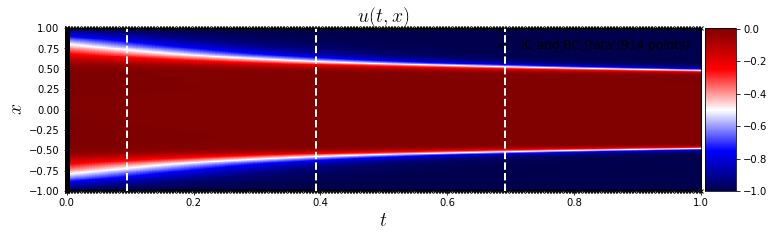

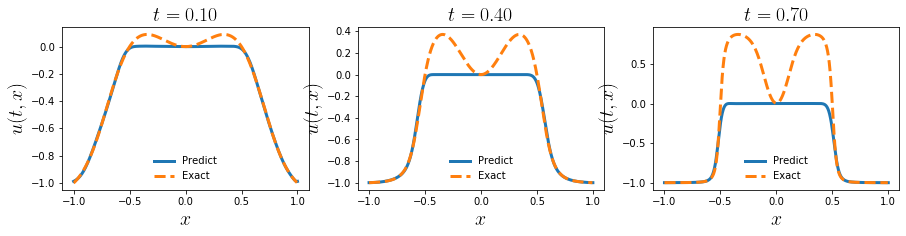

In [52]:
# 使用Tester_AC进行预测，复现复现文章中的Figure4
args = Options_AC().parse()
args.problem = Problem_AC()

args.model = ResPINN_AC(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_AC(args.problem, 512, 201, method='uniform')  

tester = Tester_AC(args)
tester.predict()